In [1]:
%load_ext autoreload
%autoreload 2

In [8]:
from graph import create_graph

graph = create_graph()


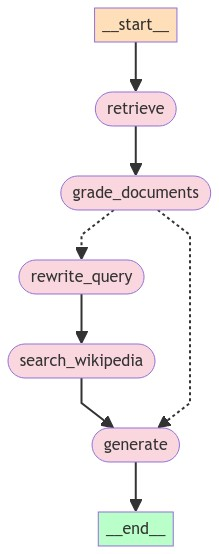

In [9]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

In [10]:
# Run
config = {"configurable": {"thread_id": "3"}}

inputs = {"question": "What did I ask you about?"}
async for output in graph.astream(inputs, config=config):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        # print(value)
    print("\n---\n")

# Final generation
print(value["generation"])


Checking memory or database...
{'question': 'What did I ask you about?', 'generation': [HumanMessage(content="The total value of 'Cash and cash equivalents' reported on December 31, 2023, was $6,874 million.", id='1b372d25-12a9-45e8-a813-0dcd3513c4b0')], 'wiki_search': True, 'documents': [Document(page_content='Table of Contents\nAirbnb, Inc.\nNotes to Condensed Consolidated Financial Statements (unaudited)\nNote 3. Supplemental Financial Statement Information\nCash, Cash Equivalents, and Restricted Cash\nThe following table reconciles cash, cash equivalents, and restricted cash reported on the Company’s unaudited condensed consolidated balance sheets to the total amount\npresented in the unaudited condensed consolidated statements of cash flows (in millions):\nDecember 31,\n2023March 31,\n2024\nCash and cash equivalents $ 6,874 $ 7,829 \nCash and cash equivalents included in funds receivable and amounts held on behalf of customers 5,769 8,665 \nRestricted cash included in prepaids and

In [ ]:
from rich import print

%load_ext rich

In [ ]:
! pip install langchain_community tiktoken langchain-openai langchainhub chromadb langchain langgraph tavily-python

# Actual functions

## Wikipedia Tool

In [ ]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper

api_wrapper = WikipediaAPIWrapper(top_k_results=5, doc_content_chars_max=1000)

tool = WikipediaQueryRun(api_wrapper=api_wrapper)
print(tool.invoke("What's a state in computer science?"))


## Load documents

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Qdrant.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    location=":memory:",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever()


## Grader

In [ ]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate


## Grading model
class DocumentGrade(BaseModel):
    """Binary score for relevance check on retrieved documents"""

    binary_score: str = Field(
        description='Document is relevant to the question, "yes" or "no"'
    )


In [ ]:
# LLM with function call
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)
structured_llm_grader = llm.with_structured_output(DocumentGrade)
structured_llm_grader


In [ ]:
# Grader Prompts
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))


## Generate

In [ ]:
agent_prompt = """You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"""

In [ ]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = ChatPromptTemplate.from_messages([("human", agent_prompt)])
prompt


In [ ]:
# Generator LLM
llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0)


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)


In [ ]:
rag_chain

## Question Re-writer

In [ ]:
# Question rewriter LLM
llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0)

# Prompt
system = """You are a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()
question_rewriter.invoke({"question": question})


# Graph

## State

In [ ]:
from typing import List
from typing_extensions import TypedDict
from langchain.schema import Document

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    wiki_search: str
    documents: List[str]


## Nodes

In [ ]:
def retrieve(state):
    print("Retrieving documents...")

    question = state["question"]

    docs = retriever.invoke(question)

    return {"question": question, "documents": docs}

In [ ]:
def generate(state):
    print("Generating answer...")

    question = state["question"]
    documents = state["documents"]

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

In [ ]:
def grade_documents(state):
    print("Grading documents...")

    question = state["question"]
    documents = state["documents"]

    filtered_docs = []
    search_wikipedia = False

    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
        )

        grade = score.binary_score

        if grade == "yes":
            print("Document is relevant to the question.")
            filtered_docs.append(doc)
        else:
            print("Document is not relevant to the question.")
            search_wikipedia = True

            continue

    return {
        "documents": filtered_docs,
        "question": question,
        "wiki_search": search_wikipedia,
    }


In [ ]:
def rewrite_query(state):
    print("Rewriting question...")

    question = state["question"]
    documents = state["documents"]

    rewritten_question = question_rewriter.invoke({"question": question})

    return {"question": rewritten_question, "documents": documents}


In [ ]:
def search_wikipedia(state):
    print("Searching Wikipedia...")

    question = state["question"]
    documents = state["documents"]

    wiki_search = tool.invoke(question)

    wiki_results = Document(page_content=wiki_search)

    documents.append(wiki_results)

    return {"question": question, "documents": documents}


## Edges

In [ ]:
def generate_or_not(state):
    print("Determining whether to query Wikipedia...")

    question = state["question"]
    wiki_search = state["wiki_search"]
    documents = state["documents"]

    if wiki_search:
        print("Rewriting query and supplementing information from Wikipedia...")
        return "rewrite_query"
    
    else:
        print("Relevant documents found.")
        return "generate"

## Build and compile

In [ ]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
import aiosqlite

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("rewrite_query", rewrite_query)
workflow.add_node("search_wikipedia", search_wikipedia)
workflow.add_node("generate", generate)

workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    generate_or_not,
    {"rewrite_query": "rewrite_query", "generate": "generate"},
)

workflow.add_edge("rewrite_query", "search_wikipedia")
workflow.add_edge("search_wikipedia", "generate")
workflow.add_edge("generate", END)

checkpoints = aiosqlite.connect("./checkpoints/checkpoint.sqlite")
memory = AsyncSqliteSaver(checkpoints) 

app = workflow.compile(checkpointer=memory)

In [4]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

NameError: name 'app' is not defined

In [ ]:
app

In [ ]:
# Run
config = {'configurable': {'thread_id': '1'}}

inputs = {"question": "What did I ask you about previously?"}
async for output in app.astream(inputs, config=config):
    for key, value in output.items():
        # Node
        print(f"Node '{key}':")
        # Optional: print full state at each node
        print(value)
    print("\n---\n")

# Final generation
print(value["generation"])

